# 5. Дилемма смещения и разброса. Полиномиальные признаки. Регуляризация

Давайте посмотрим, как это работает на практике. Работать будем с уже знакомыми нам данными — данными о домах в Бостоне.



In [12]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
%matplotlib inline
plt.style.use('seaborn-v0_8')

column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
boston_data = pd.read_csv('data/housing.csv', header=None, delimiter=r"\s+", names=column_names)
boston_data.head()

#Составляем список факторов (исключили целевой столбец)
features = boston_data.drop('MEDV', axis=1).columns
#Составляем матрицу наблюдений X и вектор ответов y
X = boston_data[features]
y = boston_data['MEDV']

В sklearn для разделения выборки на тренировочную и тестовую есть функция train_test_split() из модуля model_selection. Данная функция принимает следующие аргументы:

X и y — таблица с примерами и ответами к ним.
random_state — число, на основе которого генерируются случайные числа. Тренировочная и тестовая выборка генерируются случайно. Чтобы эксперимент был воспроизводимым, необходимо установить этот параметр в конкретное значение.
test_size — доля тестовой выборки. Параметр определяет, в каких пропорциях будет разделена выборка. Стандартные значения: 70/30, 80/20.
Функция возвращает четыре объекта в следующем порядке: тренировочные примеры, тестовые примеры, тренировочные ответы и тестовые ответы. 

Итак, давайте разделим нашу выборку на тренировочную и тестовую в соотношении 70/30:

In [13]:
from sklearn.model_selection import train_test_split
#Разделяем выборку на тренировочную и тестовую в соотношении 70/30
#Устанавливаем random_state для воспроизводимости результатов 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)
#Выводим результирующие размеры таблиц
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)
 
# Train: (354, 13) (354,)
# Test: (152, 13) (152,)

Train: (354, 13) (354,)
Test: (152, 13) (152,)


После разделения в тренировочной выборке оказались 354 наблюдения, а в тестовой — 152.

Затем обучим линейную регрессию (с помощью МНК) на тренировочных данных и рассчитаем R2 для тренировочных и тестовых данных:

In [14]:
#Создаём объект класса LinearRegression
lr_model = linear_model.LinearRegression()
#Обучаем модель по МНК
lr_model.fit(X_train, y_train)
 
#Делаем предсказание для тренировочной выборки
y_train_predict = lr_model.predict(X_train)
#Делаем предсказание для тестовой выборки
y_test_predict = lr_model.predict(X_test)
 
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict)))

# Train R^2: 0.743
# Test R^2: 0.722

Train R^2: 0.743
Test R^2: 0.722


Итак, R^2=0.743 на тренировочной выборке и R^2=0.722 на тестовой выборке. То есть показатели довольно близки друг к другу (низкий разброс ответов модели для разных выборок).

Это одно из свидетельств отсутствия переобучения. Это не удивительно, ведь линейная регрессия, построенная на 13 факторах, является довольно простой моделью: всего лишь 14 параметров, что очень мало по меркам машинного обучения. Риск переобучения возрастает с количеством факторов, которые участвуют в обучении модели.

Но что насчёт смещения? Самый простой способ оценить смещение и недообученность модели — посмотреть на значение метрики и интуитивно оценить её.

Может, наша модель слишком слабая?  R^2=0.722 — не слишком уж высокий показатель (напомним, максимум — 1). Возможно, стоит попробовать обучить более сложную модель. Например, можно построить модель полиномиальной регрессии.

Примечание. Существуют более совершенные визуальные способы оценить наличие смещения и разброса, такие как кривая обучения и кросс-валидация. О них мы ещё поговорим далее в курсе.

Построить полиномиальную регрессию в sklearn очень просто. Для начала необходимо создать полиномиальные признаки с помощью объекта класса PolynomialFeatures из модуля preprocessing. Это преобразователь, который позволит сгенерировать полиномиальные признаки любой степени и добавить их в таблицу. У него есть два важных параметра:

degree — степень полинома. По умолчанию используется степень 2.
include_bias — включать ли в результирующую таблицу столбец из единиц (x в степени 0). По умолчанию стоит True, но лучше выставить его в значение False, так как столбец из единиц и так добавляется в методе наименьших квадратов.
Примечание. Как правило, дата-сайентисты останавливаются на полиноме второй (максимум третьей) степени. Чем выше степень полинома, тем больше слагаемых, а значит, тем больше признаков и тем сложнее становится модель.

Для того чтобы подогнать генератор и рассчитать количество комбинаций степеней, мы используем метод fit(), а чтобы сгенерировать новую таблицу признаков, в которую будут включены полиномиальные признаки, используется метод transform(), в который нужно передать выборки:

In [15]:
from sklearn import preprocessing

#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.transform(X_test)
#Выводим результирующие размерности таблиц
print(X_train_poly.shape)
print(X_test_poly.shape)
 
# (354, 104)
# (152, 104)

(354, 104)
(152, 104)


Итак, мы сгенерировали новые тренировочные и тестовые наборы данных. В каждой таблице в дополнение к 13 изначальным признакам добавилась 91 полиномиальная комбинация степени 2.

В результате мы получили два numpy-массива:

In [16]:
print(type(X_train_poly))
print(type(X_test_poly))
# <class 'numpy.ndarray'>
# <class 'numpy.ndarray'>

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Теперь попробуем скормить наши данные модели линейной регрессии, чтобы найти коэффициенты полинома по МНК-алгоритму:



In [17]:
#Создаём объект класса LinearRegression
lr_model_poly = linear_model.LinearRegression()
#Обучаем модель по МНК
lr_model_poly.fit(X_train_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lr_model_poly.predict(X_train_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lr_model_poly.predict(X_test_poly)
 
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))

# Train R^2: 0.929
# Test R^2: 0.268

Train R^2: 0.929
Test R^2: 0.268


Потрясающе! На тренировочной выборке коэффициент детерминации R^2=0.929, то есть наша модель описывает почти 93 % зависимости в данных.

Смотрим на показатели тестовой выборки и сразу «спускаемся с небес на землю»:  R^2=0.268. Метрика значительно ниже, чем на тренировочном наборе. Это и есть переобучение модели. Из-за своей сложности (количества факторов) модель полностью адаптировалась под тренировочные данные, но взамен получила высокий разброс в показателях на данных, которые она не видела ранее. 

Примечание. Модель линейной регрессии может быть неустойчивой, даже если показатели на тренировочной и тестовой выборках довольно близки, однако все коэффициенты уравнения имеют огромные значения.

Такая модель никому не нужна, так как она не отражает действительности.

Однако не стоит расстраиваться — есть один замечательный метод, который сможет спасти нашу модель от переобучения, и это регуляризация.

### Задание 5.6
1 point possible (graded)
Дано три признака:  x1 ,  x2 ,  x3 . Сколько коэффициентов (с учётом свободного члена) будет в уравнении линейной регрессии после генерации полиномиальных признаков? Степень полинома — 2.
Имейте в виду, что признаки  x1x2  и  x2x1  считаются одним и тем же признаком, то есть не учитываются дважды.

$$\hat{y}=w_{0}+w_{1} x_{1}+w_{2} x_{2}+w_{3} x_{3}+w_{4} x_{1}^{2}+w_{5} x_{2}^{2}+w_{6} x_{3}^{2}+w_{7} x_{1} x_{2}+w_{8} x_{1} x_{3}+w_{9} x_{2} x_{3}$$

w0 

w1x1 w2x2 w3x3 

w4x1x2 w5x1x3 w6x2x3

w7x1^2 w8x2^2 w9x3^2

1+3+3+3 = 10

Практика показывает, что обучение линейной регрессии с большим количеством признаков рекомендуется производить на стандартизованных (нормализованных) данных.

Примечание. Часто возникает вопрос: как правильно проводить стандартизацию/нормализацию при наличии тренировочной и тестовой выборки?

Вы обучаете (fit()) преобразование на тренировочной выборке и используете его с одними и теми же параметрами на тренировочной и тестовой выборке (transform()). Если производить подгонку на каждой из выборок в отдельности, вы внесёте смещение в модель.

Стандартизацию (нормализацию) полезнее проводить перед генерацией полиномиальных признаков, иначе можно потерять масштаб полиномов.

Давайте предобработаем наши данные:

In [18]:
#Инициализируем стандартизатор StandardScaler
scaler = preprocessing.StandardScaler()
#Подгоняем параметры стандартизатора (вычисляем среднее и СКО)
scaler.fit(X_train)
#Производим стандартизацию тренировочной выборки
X_train_scaled = scaler.transform(X_train)
#Производим стандартизацию тестовой выборки
X_test_scaled = scaler.transform(X_test)
 
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_scaled_poly = poly.transform(X_train_scaled)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_scaled_poly = poly.transform(X_test_scaled)
#Выводим результирующие размерности таблиц
 
print(X_train_scaled_poly.shape)
print(X_test_scaled_poly.shape)
# (354, 104)
# (152, 104)

(354, 104)
(152, 104)


→ В sklearn методы регуляризации реализованы в классах Lasso (L1-регуляризация) и Ridge (L2-регуляризация). Оба метода осуществляют поиск параметров с добавлением регуляризации. Процесс обучения и предсказания не отличается от обычной линейной регрессии.

Давайте построим модель линейной регрессии с L1-регуляризацией на сгенерированных нами ранее полиномиальных признаках.

Главный параметр инициализации Lasso — это alpha, коэффициент регуляризации. По умолчанию alpha=1. Практика показывает, что это довольно сильная регуляризация для L1-метода. Давайте установим значение этого параметра на 0.1.

In [19]:
#Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr_poly = linear_model.Lasso(alpha=0.1)
#Обучаем модель
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))

# Train R^2: 0.879
# Test R^2: 0.882

Train R^2: 0.879
Test R^2: 0.882


Обратите внимание на то, как изменились значения метрик. Да, на тренировочной выборке R2=0.879. Метрика упала (до стандартизации + регуляризации значение R2 было 0.929). Однако метрика ощутимо выросла на тестовой выборке: R2=0.882 (ранее она была равна 0.268). Мы смогли преодолеть переобучение.

Давайте выведем значения коэффициентов модели, округлив их до третьего знака после запятой:



In [20]:
print(np.round(lasso_lr_poly.coef_, 3))

[-0.     0.    -0.038  0.    -0.523  2.766 -0.355 -0.605  0.    -0.595
 -0.763  0.    -3.259 -0.    -0.     0.     3.132 -0.141  0.     0.
  0.    -0.     0.     0.    -0.015 -0.     0.063 -0.    -0.     0.
  0.159 -0.    -0.    -0.     0.     0.07  -0.    -0.     0.017  0.
  0.    -0.     0.     0.     0.     0.    -0.    -0.     0.     0.46
 -0.808 -0.643  0.    -0.    -0.     0.    -0.     0.    -0.43  -0.348
 -0.511 -0.     0.    -0.14  -0.    -0.277  0.    -0.     0.223 -0.
 -0.    -0.836 -0.054 -0.421  0.019 -0.784  0.    -0.     0.706  0.
 -0.    -0.335 -0.198  0.    -0.     0.     0.205 -0.     0.531 -0.
  0.     0.048 -0.    -0.292  0.677  0.81  -0.    -1.151 -0.    -0.
 -0.    -0.288 -0.356  0.429]


Обратите внимание: большая часть коэффициентов обнулилась. Это значит, что признаки, которые соответствуют этим коэффициентам, не используются в прогнозе модели Lasso-регрессии.

Теперь давайте на тех же данных обучим модель линейной регрессии с L2-регуляризацией. Для L2-регуляризации параметр alpha по умолчанию равен 1. Давайте попробуем использовать значение параметра alpha=10:

In [21]:
#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge(alpha=10)
#Обучаем модель
ridge_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))
 

# Train R^2: 0.907
# Test R^2: 0.831

Train R^2: 0.907
Test R^2: 0.848


Значения метрики R^2 на тестовой выборке для L1-регуляризации получились немного выше. В первую очередь мы всегда ориентируемся на тестовую выборку — это данные, которые модель ещё не видела.

Давайте выведем значения коэффициентов модели, округлив их до третьего знака после запятой:


In [22]:
print(np.round(ridge_lr_poly.coef_, 3))

[ 0.128 -0.049  0.084  0.117 -0.932  2.848 -1.008 -1.464  0.909 -0.908
 -0.653  0.971 -2.605  0.085 -0.032  0.466  2.721 -0.507  0.986  0.309
 -0.391 -0.714  0.376 -0.379  0.072  0.287  0.143 -0.138 -0.014  0.315
  0.05  -0.409 -0.316  0.075  0.702  0.08  -0.281 -0.37   0.511  0.175
  0.72   0.282  0.477  0.888 -0.012  0.074 -0.052  0.166 -0.263  0.414
 -1.129 -0.852  0.273  0.227 -0.106  0.368 -0.137 -0.241 -0.697 -0.177
 -0.326 -0.524  0.882 -0.637  0.344 -0.439 -0.006  0.386  0.233 -0.535
  0.111 -0.802 -0.662 -0.56   0.22  -1.001  0.123  0.144  0.889 -0.114
 -0.086 -1.022 -0.71   1.08  -0.446 -0.178 -0.07  -0.496  0.874 -0.926
  0.717  0.601 -0.49  -0.723  0.308  1.086 -0.448 -1.256  0.057  0.354
 -0.059 -0.433 -0.791  0.177]


Видно, что L2-регуляризация не обнуляет коэффициенты — она использует для предсказания все признаки.


Параметр alpha имеет очень важное значение: от его выбора зависит, как сильно мы будем штрафовать модель за переобучение. Важно найти значение, которое приносит наилучший эффект.

Попробуйте вручную изменять параметр alpha для построенных ранее моделей. Согласитесь, это не очень удобно.

Давайте организуем процесс перебора параметров модели: создадим цикл, в котором будем перебирать 20 различных значений alpha в диапазоне от 0.001 до 1. Такой список проще всего создать с помощью функции linspace() из библиотеки numpy.

В цикле будем обучать модель линейной регрессии и L1-регуляризацией (Lasso), вычислять значения метрики R2 на тренировочной и тестовой выборках и заносить результаты в списки train_scores и test_scores:

In [23]:
#Создаём список из 20 возможных значений от 0.001 до 1
alpha_list = np.linspace(0.001, 1, 20)
#Создаём пустые списки, в которые будем добавлять результаты 
train_scores = []
test_scores = []
for alpha in alpha_list:
    #Создаём объект класса линейной регрессии с L1-регуляризацией
    lasso_lr_poly = linear_model.Lasso(alpha=alpha, max_iter=10000)
    #Обучаем модель
    lasso_lr_poly.fit(X_train_scaled_poly, y_train)
    #Делаем предсказание для тренировочной выборки
    y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
    #Делаем предсказание для тестовой выборки
    y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
    #Рассчитываем коэффициенты детерминации для двух выборок и добавляем их в списки
    train_scores.append(metrics.r2_score(y_train, y_train_predict_poly))
    test_scores.append(metrics.r2_score(y_test, y_test_predict_poly))

В результате выполнения данного кода в списках train_scores и test_scores появятся 20 различных значений R^2 на тренировочной и тестовой выборках.

Давайте построим линейные графики, которые покажут, как меняется метрика R^2 на тренировочной и тестовой выборках в зависимости от alpha:

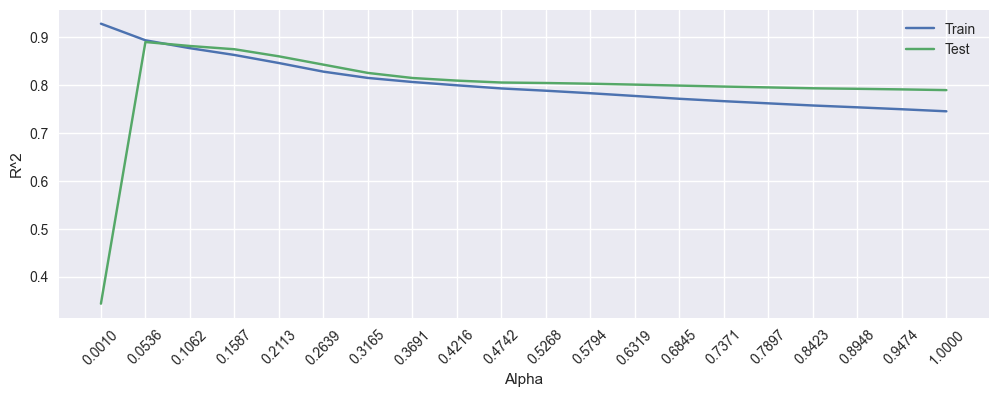

In [24]:
#Визуализируем изменение R^2 в зависимости от alpha
fig, ax = plt.subplots(figsize=(12, 4)) #фигура + координатная плоскость
ax.plot(alpha_list, train_scores, label='Train') #линейный график для тренировочной выборки
ax.plot(alpha_list, test_scores, label='Test') #линейный график для тестовой выборки
ax.set_xlabel('Alpha') #название оси абсцисс
ax.set_ylabel('R^2') #название оси ординат
ax.set_xticks(alpha_list) #метки по оси абсцисс
ax.xaxis.set_tick_params(rotation=45) #поворот меток на оси абсцисс
ax.legend(); #отображение легенды

С помощью графика мы можем подобрать оптимальное значение параметра alpha. Нам нужна такая точка на оси абсцисс, при которой на тестовой выборке наблюдается максимальная метрика и при этом разница между метриками на тренировочной и тестовой выборках минимальна.

Видно, что R2 на тестовой выборке достигает наибольшего значения в точке 0.0536. Причём в этой точке наблюдается примерное равенство метрик на каждом наборе данных. Далее метрика на тестовой выборке начинает падать.

Обратите внимание, что на тренировочной выборке R2 непрерывно падает с ростом alpha. Оно и понятно, ведь чем больше alpha, тем сильнее регуляризация и тем меньше модель подстраивается под обучающую выборку.

Давайте подставим значение alpha=0.0536 в модель Lasso и получим результат:



In [25]:
#Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr_poly = linear_model.Lasso(alpha=0.0536)
#Обучаем модель 
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))

# Train R^2: 0.894
# Test R^2: 0.890

Train R^2: 0.894
Test R^2: 0.890


Итак, метрика R^2 выросла благодаря тому, что мы смогли подобрать оптимальное значение параметра alpha.